In [16]:
import pandas as pd
import numpy as np
from pandas import DataFrame as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
aflt = pd.read_csv('AFLT_160120_161213.csv', sep=',')
aflt = aflt.drop(columns={'<TICKER>', '<PER>', '<TIME>'})
aflt['<DATE>'] = pd.to_datetime(aflt['<DATE>'], format='%Y%m%d')
aflt = aflt.rename(columns={'<DATE>':'Date', '<CLOSE>':'Price'})

In [18]:
sber = pd.read_csv('SBER_160120_161213.csv', sep=',')
sber = sber.drop(columns={'<TICKER>', '<PER>', '<TIME>'})
sber['<DATE>'] = pd.to_datetime(sber['<DATE>'], format='%Y%m%d')
sber = sber.rename(columns={'<DATE>':'Date', '<CLOSE>':'Price'})

In [19]:
aflt.head(5)

,Date,Price
0,2016-01-20,52.00
1,2016-01-21,50.99
2,2016-01-22,52.03
3,2016-01-25,51.10
4,2016-01-26,51.28


In [20]:
sber.head()

,Date,Price
0,2016-01-20,83.83
1,2016-01-21,86.00
2,2016-01-22,91.50
3,2016-01-25,91.00
4,2016-01-26,91.50


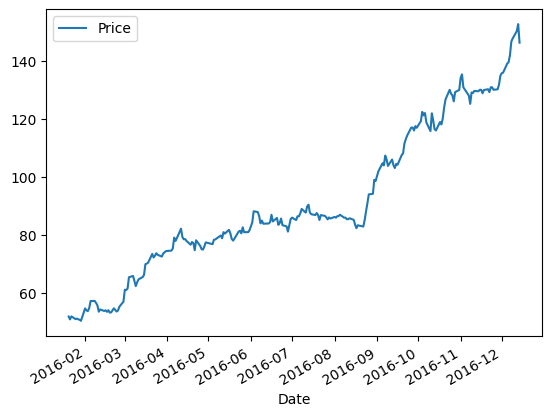

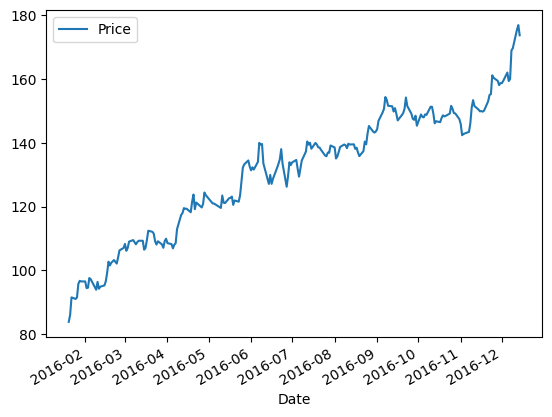

In [21]:
aflt.plot(x='Date',y='Price');
sber.plot(x='Date',y='Price');

In [22]:
aflt['Profit'] = aflt['Price'].pct_change()
sber['Profit'] = sber['Price'].pct_change()

In [23]:
aflt

,Date,Price,Profit
0,2016-01-20,52.00,NaN
1,2016-01-21,50.99,-0.019423
2,2016-01-22,52.03,0.020396
3,2016-01-25,51.10,-0.017874
4,2016-01-26,51.28,0.003523
...,...,...,...
225,2016-12-08,146.58,0.032981
226,2016-12-09,147.68,0.007504
227,2016-12-12,150.20,0.017064
228,2016-12-13,152.60,0.015979


In [24]:
sber

,Date,Price,Profit
0,2016-01-20,83.83,NaN
1,2016-01-21,86.00,0.025886
2,2016-01-22,91.50,0.063953
3,2016-01-25,91.00,-0.005464
4,2016-01-26,91.50,0.005495
...,...,...,...
225,2016-12-08,168.98,0.056455
226,2016-12-09,169.66,0.004024
227,2016-12-12,175.40,0.033832
228,2016-12-13,176.90,0.008552


In [25]:
af = aflt.Profit.to_numpy()[1:201]
sb = sber.Profit.to_numpy()[1:201]

<AxesSubplot: xlabel='Доходность', ylabel='$F_{sber}$'>

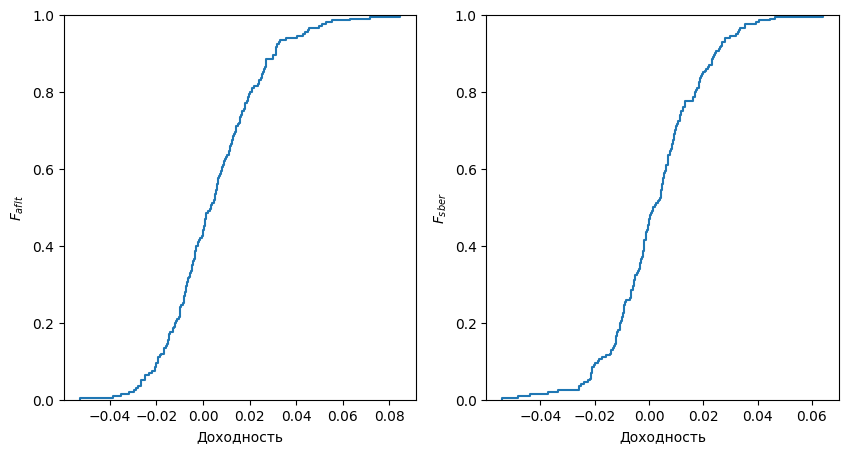

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_xlabel('Доходность')
ax[1].set_xlabel('Доходность')
ax[0].set_ylabel('$F_{aflt}$')
ax[1].set_ylabel('$F_{sber}$')
sns.ecdfplot(af, ax=ax[0])
sns.ecdfplot(sb, ax=ax[1])

In [27]:
E = lambda t: np.sum(t)/np.size(t)
D = lambda t: E(t*t) - E(t)**2

print('E(Аэрофлот) =', round(E(af), 3))
print('E(Сбер) =', round(E(sb), 3))
print('D(Аэрофлот) =', round(D(af), 6))
print('D(Сбер) =', round(D(sb), 6))
print('r(Аэрофлот, Сбер) =', np.corrcoef(af, sb)[0, 1])

E(Аэрофлот) = 0.005
E(Сбер) = 0.003
D(Аэрофлот) = 0.000429
D(Сбер) = 0.000296
r(Аэрофлот, Сбер) = 0.19233216816836957


In [28]:
af = np.copy(np.sort(af))
sb = np.copy(np.sort(sb))

In [29]:
def VaR(y, alpha):
    h = y.shape[0] * (1 - alpha)
    return y[int(np.floor(h))] + (h - np.floor(h)) * (y[int(np.ceil(h))] - y[int(np.floor(h))])

In [30]:
alpha = 0.95
CVaR = lambda t, alpha: np.average(t[t < VaR(t, alpha)])

print('VaR(Аэрофлот)  =', round(VaR(af, alpha), 4))
print('VaR(Сбер)     =', VaR(sb, alpha).__round__(4))
print('CVaR(Аэрофлот) =', CVaR(af, alpha).__round__(4))
print('CVaR(Сбер)    =', CVaR(sb, alpha).__round__(4))

VaR(Аэрофлот)  = -0.025
VaR(Сбер)     = -0.0218
CVaR(Аэрофлот) = -0.0317
CVaR(Сбер)    = -0.0328


In [31]:
def find_opt_var_port(step, trust_level):
    nodes = int(1 / step + 1)
    var_variants = np.zeros(nodes)
    print('VaR(Аэрофлот Сбер) при шаге', step)
    for i in range(nodes):
        cur_portfolio = i * step * af + (1 - i * step) * sb
        var_variants[i] = VaR(cur_portfolio, trust_level)
        print('VaR(', (i * step).__round__(1),\
              (1 - i * step).__round__(1), ') =',\
              var_variants[i].__round__(5))
    print('Оптимальный портфель:')
    print('Аэрофлот -', np.argmax(var_variants) * step.__round__(1))
    print('Сбер -', (1 - np.argmax(var_variants) * step).__round__(1))

In [32]:
find_opt_var_port(0.1, 0.95)

VaR(Аэрофлот Сбер) при шаге 0.1
VaR( 0.0 1.0 ) = -0.02176
VaR( 0.1 0.9 ) = -0.02209
VaR( 0.2 0.8 ) = -0.02241
VaR( 0.3 0.7 ) = -0.02274
VaR( 0.4 0.6 ) = -0.02306
VaR( 0.5 0.5 ) = -0.02338
VaR( 0.6 0.4 ) = -0.02371
VaR( 0.7 0.3 ) = -0.02403
VaR( 0.8 0.2 ) = -0.02436
VaR( 0.9 0.1 ) = -0.02468
VaR( 1.0 0.0 ) = -0.02501
Оптимальный портфель:
Аэрофлот - 0.0
Сбер - 1.0
